In [1]:
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso


## **Question 2** : Preliminaries

Write the constrained problem minimization 

$$
\begin{cases}
\displaystyle
\min_{\nu}   \left( \nu^{T} Q \nu + p^{T} \nu \right)\\ 
s.t. A\nu \preceq b
\end{cases}
$$
as unconstrained problem minimization 

$$
	    \min_{\nu} g_{t}(\nu) \triangleq t \left( \nu^{T} Q \nu + p^{T} \nu \right) - \sum_{i=1}^{2d} \log \left( b_i - \left[ A \nu \right]_{i} \right)
$$



In [2]:
# objective without constraint
def dual(v, Q, p):
  return v.T.dot(Q).dot(v) + p.T.dot(v)

In [3]:
class PbUnConstraint(object):
  def __init__(self, Q, p, A, b, t):
    self.Q = Q 
    self.p = p
    self.A = A
    self.b = b
    # self.D, self.N = A.shape # N= n et D = 2d
    self.p = p
    self.t = t

  # objective without constraint
  def obj(self, v):
    return v.T.dot(Q).dot(v) + p.T.dot(v)

  # objective with constraint 
  def barobj(self, v):
    obj_function = self.t * (v.T.dot(Q).dot(v) + p.T.dot(v))
    if (b - np.dot(A, v) <= 0).any():
      return float("NaN")
    else :
      constraint_function = A.shape[0] * np.mean(np.log(b - np.dot(A, v))) # on enlève 1/2d
      return obj_function - constraint_function


  # gradient
  def grad(self, v):
    phi = (1. / (b - np.dot(A, v)))
    # diagm = diag * np.eye(A.shape[0])
    return (2 * np.dot(Q, v) + p) * self.t + (A.T).dot(phi)

  # hessian
  def hess(self, v):
    phi = b - np.dot(A, v)
    # diag = 1 / (d**2)
    # diagm = diag * np.eye(A.shape[0])
    diagm = np.diag(phi)**2
    return 2 * Q * self.t + (A.T).dot(diagm).dot(A)

In [4]:
def lineSearch(f, df, v, dv, alpha, beta):
  t = 1
  while (np.isnan(f(v + t * dv)) or f(v + t * dv) >=  f(v) + alpha * t * (df(v).T.dot(dv))) and ( t > 1e-6):
    t *= beta
    if np.any(b - np.dot(A, v + t * dv) <= 0):
            return t
  return t

## **Question 2**

Write a function $v\_{seq} = centering\_step(Q, p, A, b, t, v0, eps)$ which implements the Newton method to solve the centering step given the inputs $(Q,p, A, b)$, the barrier method parameter t (see lectures), initial variables $v0$ and a target precision \epsilon. The function outputs the
sequence of variables iterates $(v_i)_{
i=1,...,n_{\epsilon}}$
, where $n_{\epsilon}$ is the number of iterations to obtain the $\epsilon$
precision. Use a backtracking line search with appropriate parameters





In [5]:
def centering_step(v0, Q, p, A, b, t, eps=1e-9, alpha=.5, beta=.9, max_iter=500):
  v_seq = [v0]
  i=0
  v = v0

  # Class instanciate
  pb = PbUnConstraint(Q, p, A, b, t)
  # to simplify notations
  f = lambda v :  pb.barobj(v)
  df = lambda v : pb.grad(v)
  dfdf = lambda v : pb.hess(v)
  
  while i < max_iter : 

    # Newton method
    dv = np.linalg.pinv(dfdf(v)).dot(df(v))
    lambda2 = df(v).T.dot(dv)
    if ((0.5 * lambda2) <= eps).any():
      break

    # step size by backtracking line search
    t = lineSearch(f, df, v, dv, alpha = alpha, beta = beta)
    v = v - t * dv 
    v_seq.append(v)
    i+=1
  
  return v_seq

Write a function $v\_seq = barr\_method(Q, p, A, b, v0, eps)$ which implements the barrier
method to solve QP using precedent function given the data inputs $(Q, p, A, b)$, a feasible point
$v_0$, a precision criterion $\epsilon$. The function outputs the sequence of variables iterates $(v_i){ i=1,...,n_{\epsilon}}$
where $n_{\epsilon}$ is the number of iterations to obtain the $\epsilon$ precision

In [6]:
def barr_method(v0, Q, p, A, b, mu, eps = 1e-9, max_iter=500):

  #Initialization
  v = v0
  v_seq = [v0]
  m = A.shape[0]
  t = 1 

  # Class instanciate
  pb = PbUnConstraint(Q, p, A, b, t)
  # to simplify notations
  f = lambda v : pb.obj(v) # Centering step Barrier method
  df = lambda v : pb.grad(v)
  dfdf = lambda v : pb.hess(v)


  # centering step 
  while (m / t) >= eps:
    v = centering_step(v_seq[-1], Q, p, A, b, t, eps=1e-9, alpha=.5, beta=.9, max_iter=500)[-1]
    v_seq.append(v)
    t *= mu

  return v_seq


## **Question 3**

Test your function on randomly generated matrices $X$ and observations $y$ with $\lambda  = 10$. Plot precision
criterion and gap $f(v_t) − f^*$
in semilog scale (using the best value found for f as a surrogate for $f^*$).
Repeat for different values of the barrier method parameter $\mu = 2, 15, 50, 100 . . .$ and check the impact
on $w$. What would be an appropriate choice for $\mu$?


In [7]:
def make_data(n, d, lamda=10):

    X = 3 * np.random.randn(n, d)
    y = 5 + 1.5 * np.random.randn(n)

    Q = np.eye(n) / 2
    p = - y

    A = np.concatenate((X.T, - X.T), axis=0)
    b = lamda * np.ones(2 * d)

    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

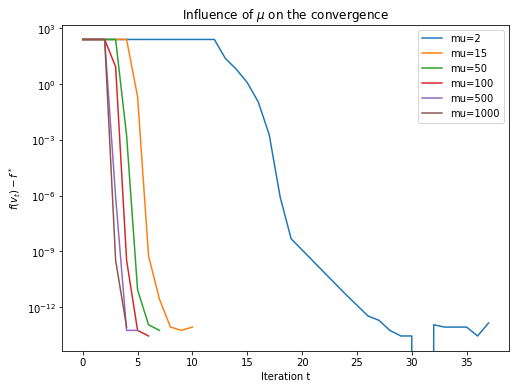

In [8]:
n, d, lamda = 20, 50, 10
X, w,  y, Q, p, A, b, v0 = make_data(n, d, lamda)
eps = 1e-9
alpha, beta = .5, .9
max_iter = 500

mu_values = [2, 15, 50, 100, 500, 1000]
results = [barr_method(v0, Q, p, A, b, mu, eps = 1e-9, max_iter=500) for mu in mu_values]
f_values = [[dual(v, Q, p) for v in results[i]] for i in range(len(results))]
f_star = np.infty
for i in range(len(results)):
    for v in f_values[i]:
        if f_star > v:
            f_star = v

plt.figure(figsize=(8, 6))
plt.xlabel('Iteration t')
plt.ylabel('$f(v_t) - f^*$')
plt.title('Influence of $\\mu$ on the convergence')
for i in range(len(results)):
    plt.semilogy(f_values[i] - f_star, label='mu={}'.format(mu_values[i]))
plt.legend()
plt.show()

We see that the number of iterations increases if $\mu$ decreases. We also notice that
that the different initializations give almost the same result $f^*$, except for
$\mu = 2$, which gives a better result than the others.

In [9]:
mus = [2, 5, 10, 15, 30, 50, 100]
ve = {}
for mu in mus:
    ve[mu] = barr_method(v0, Q, p, A, b, mu, eps = 1e-9, max_iter=500)[-1]

In [12]:
ve

{2: array([5.26104967, 2.67234425, 2.95238961, 3.97801157, 3.05261139,
        6.81966736, 5.37301149, 7.1635455 , 3.73556636, 1.76617304,
        6.26365719, 4.70629056, 3.90580129, 6.22551131, 4.05304981,
        6.31829467, 7.52353819, 4.26390319, 4.96447997, 3.96913018]),
 5: array([5.26104967, 2.67234425, 2.95238961, 3.97801157, 3.05261139,
        6.81966736, 5.37301149, 7.1635455 , 3.73556636, 1.76617304,
        6.26365719, 4.70629056, 3.90580129, 6.22551131, 4.05304981,
        6.31829467, 7.52353819, 4.26390319, 4.96447997, 3.96913018]),
 10: array([5.26104967, 2.67234425, 2.95238961, 3.97801157, 3.05261139,
        6.81966736, 5.37301149, 7.1635455 , 3.73556636, 1.76617304,
        6.26365719, 4.70629056, 3.90580129, 6.22551131, 4.05304981,
        6.31829467, 7.52353819, 4.26390319, 4.96447997, 3.96913018]),
 15: array([5.26104967, 2.67234425, 2.95238961, 3.97801157, 3.05261139,
        6.81966736, 5.37301149, 7.1635455 , 3.73556636, 1.76617304,
        6.26365719, 4.706290

In [10]:
we = {}
w = np.random.rand(50,1)
for mu in mus:
    we[mu] = np.dot(np.linalg.pinv(X),ve[mu] + y)

In [11]:
from tabulate import tabulate
values = []
for mu in mus:
    difference = np.abs(we[mu] - w)
    values.append([mu, np.max(difference), np.min(difference), np.mean(difference), np.std(difference)])
print("|w - w*|")
print(tabulate(values, headers=["mu", "max", "min", "mean", "std"]))

|w - w*|
  mu      max          min      mean       std
----  -------  -----------  --------  --------
   2  1.48713  0.000124303  0.599588  0.365566
   5  1.48713  0.000124303  0.599588  0.365566
  10  1.48713  0.000124303  0.599588  0.365566
  15  1.48713  0.000124303  0.599588  0.365566
  30  1.48713  0.000124303  0.599588  0.365566
  50  1.48713  0.000124303  0.599588  0.365566
 100  1.48713  0.000124303  0.599588  0.365566
